# Partial Configuration Identification


We consider performance analysis in highly variable systems, such as x264, with a large number of configurations options and input features, and multiple performance metrics.
Our goal in this work to identify partial stable configurations from a set of measurements.
A stable configuration is a configuration that is consistently high performing, indicated by its presence in the Pareto front of configurations for each of the videos in the measurement set.
In the ideal case, we identify a single configuration that is present in every Pareto front, i.e. it is never dominated by another configuration. This would be the premier configuration to test for every new input.
Otherwise, we can identify the subset of configurations options that most frequently occur together and propose these as a partial configuration. The extensions of this partial configuration can then form a reduced set of candidate configurations to consider for evaluation/application. The extensions can be similarly determined from the obtained measurements and potentially be weighted by their expected performance resp. their influence on certain performance metrics.

We raise the following research questions:
- Do stable configurations exist? Are they partial or full configurations?
- Do the best configurations share common parameters?
- What is the largest common set of parameters with minimum quality?
- How much do the results vary if we further partition the data, e.g. by video category?
   
Technically speaking, we can apply techniques from data mining, e.g. frequent itemset mining, to determine the core partial configurations, but we do not have to rely on complex statistical machine learning techniques, which makes this approach simple and interpretable.
    
We present an in-depth analysis of our approach on a large-scale dataset of video encodings using the x264 video encoder.
Additionally, we confirm the applicability of our approach on seven others configurable systems (Luc's dataset: gcc, imagemagick, lingeling, nodeJS, poppler, SQLite, xz).

First we import some packages.
`common` is our shared library for shared functions like loading, ranking, etc.

In [1]:
import pandas as pd
import numpy as np
import plotnine as p9
from common import load_data, pareto_rank

from sklearn.preprocessing import OneHotEncoder
from mlxtend.frequent_patterns import fpgrowth, fpmax

We load the data for one system, here `x264`.

In [2]:
(
    perf_matrix,
    input_features,
    config_features,
    all_performances,
    input_preprocessor,
    config_preprocessor,
) = load_data(
    system="x264", data_dir="../data", input_properties_type="tabular"
)

In [18]:
input_features

,resolution,WIDTH,HEIGHT,SPATIAL_COMPLEXITY,TEMPORAL_COMPLEXITY,CHUNK_COMPLEXITY_VARIATION,COLOR_COMPLEXITY,category
inputname,,,,,,,,
Animation_1080P-01b3,1080,1920,1080,0.098,0.004,0.017,0.005,Animation
Animation_1080P-05f8,1080,1920,1080,1.229,0.454,15.962,0.794,Animation
Animation_1080P-0c4f,1080,1920,1080,1.714,0.136,9.048,0.000,Animation
Animation_1080P-0cdf,1080,1920,1080,1.330,0.451,3.677,0.181,Animation
Animation_1080P-18f5,1080,1920,1080,2.452,0.137,3.918,0.329,Animation
...,...,...,...,...,...,...,...,...
Vlog_720P-561e,720,1280,720,2.188,0.034,1.128,0.390,Vlog
Vlog_720P-5d08,720,732,720,4.128,0.285,2.126,0.248,Vlog
Vlog_720P-60f8,720,1280,720,1.554,0.344,2.466,0.250,Vlog


In [3]:
config_features

,cabac,ref,subme,mixed_ref,me_range,trellis,8x8dct,fast_pskip,chroma_qp_offset,bframes,...,analyse,me,direct,deblock,b_adapt,b_pyramid,open_gop,rc_lookahead,scenecut,weightb
configurationID,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,16,0,0,1,0,0,...,0:0,dia,NaN,0:0:0,NaN,NaN,NaN,NaN,0.0,NaN
2,1,1,1,0,16,0,1,1,0,3,...,0x3:0x3,dia,auto,1:0:0,1.0,2.0,0.0,NaN,40.0,1.0
3,1,1,2,0,16,0,1,1,0,3,...,0x3:0x113,hex,auto,1:0:0,1.0,2.0,0.0,10.0,40.0,1.0
4,1,2,4,0,16,0,1,1,0,3,...,0x3:0x113,hex,auto,1:0:0,1.0,2.0,0.0,20.0,40.0,1.0
5,1,2,6,1,16,1,1,1,-2,3,...,0x3:0x113,hex,auto,1:0:0,1.0,2.0,0.0,30.0,40.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,1,16,7,1,24,2,1,0,-2,16,...,0x3:0x133,tesa,spatial,1:0:0,2.0,2.0,0.0,60.0,40.0,1.0
198,1,16,11,1,24,2,1,0,-2,16,...,0x3:0x133,hex,spatial,1:0:0,2.0,2.0,0.0,60.0,40.0,1.0
199,1,16,11,1,24,2,1,0,-2,16,...,0x3:0x3,tesa,spatial,1:0:0,2.0,2.0,0.0,60.0,40.0,1.0


## Pareto Front Calculation

We take the matrix of all measurements and calculate the Pareto ranks for each configuration per input. For this, we consider all measured performances, but we can change this to any subset.

In [4]:
performances = ["fps", "cpu"]
performances = ["size", "etime"]
icm = (
    perf_matrix[["inputname", "configurationID"] + performances]
    .sort_values(["inputname", "configurationID"])
    .set_index(["inputname", "configurationID"])
)
icm["ranks"] = icm.groupby("inputname", group_keys=False).apply(pareto_rank)

For quick visualization, we plot the distribution of measurements and their ranks for one input.
The first Pareto front is in the lower left corner.

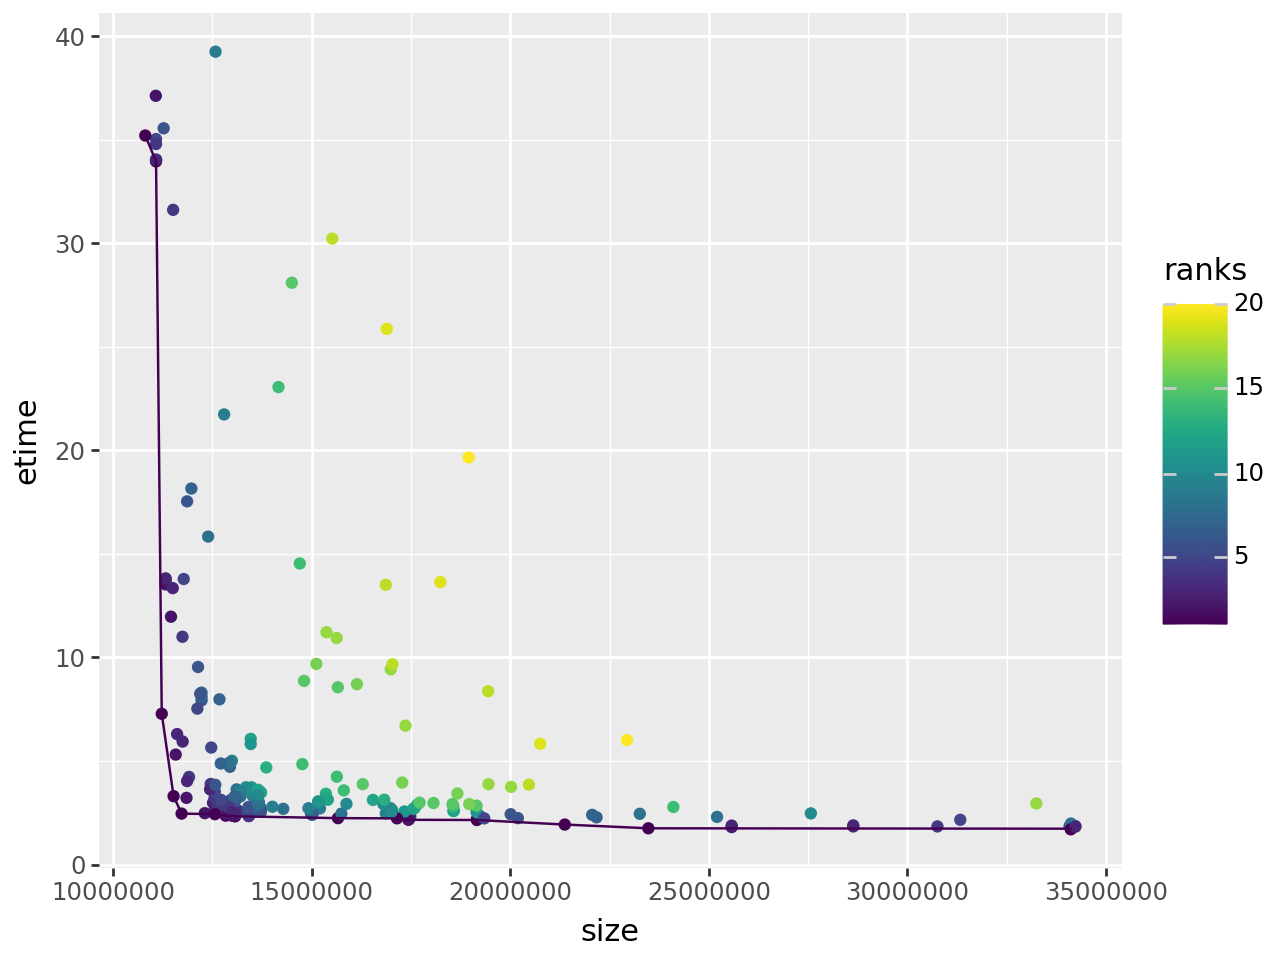

In [14]:
(
    p9.ggplot(icm.loc[("Animation_1080P-0c4f")], p9.aes(x="size", y="etime", color="ranks"))
    + p9.geom_point()
    + p9.geom_line(icm[icm.ranks == 1].loc[("Animation_1080P-0c4f")])
)

Let's look at the distribution of the ranks. How many ranks are there and how large are they over all inputs?

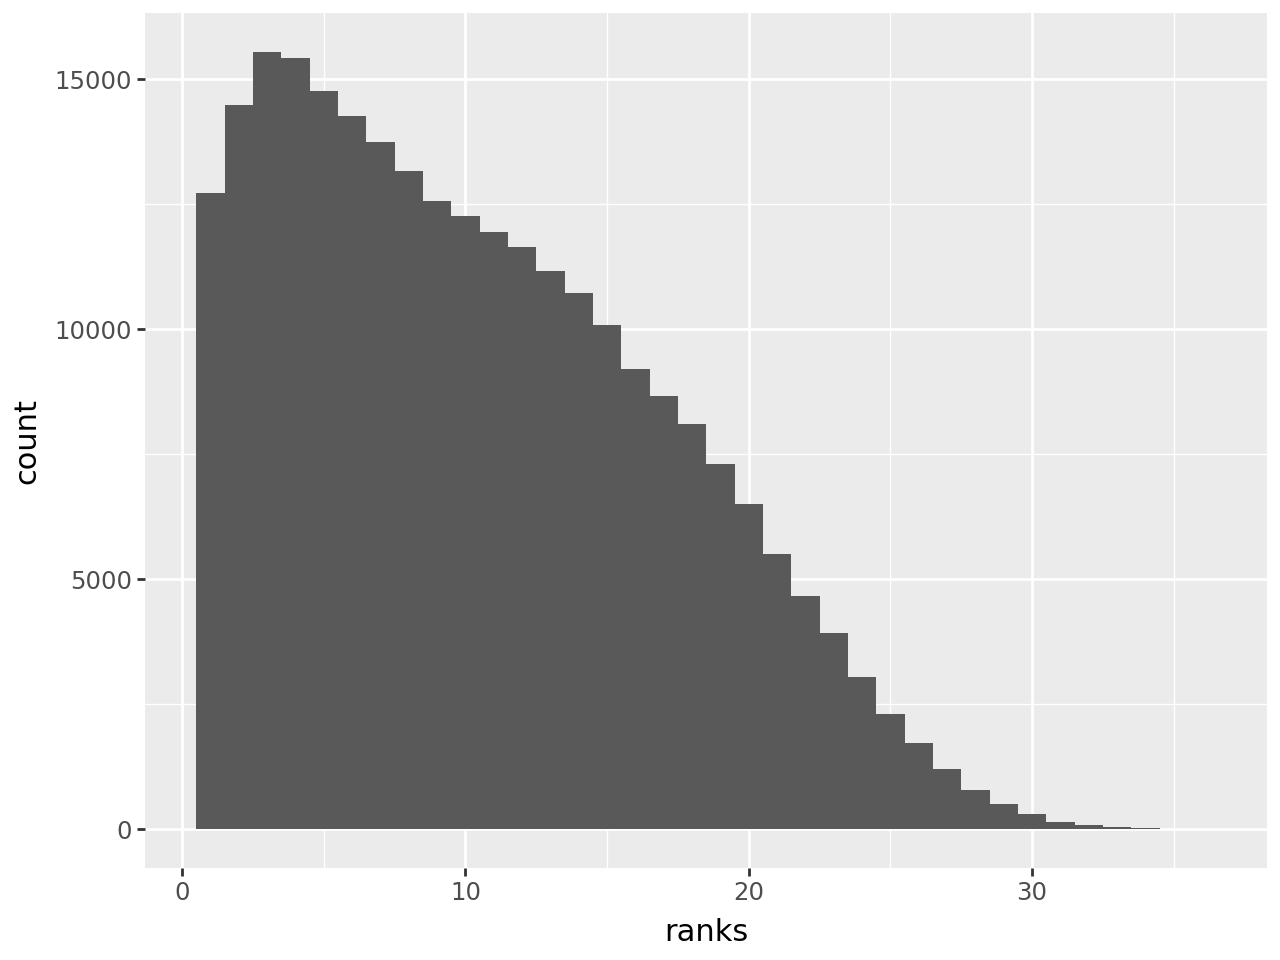

In [6]:
(
    p9.ggplot(icm, p9.aes(x="ranks"))
    + p9.geom_histogram(binwidth=1)
)

For further mining, we are only interested in the best performing configurations, i.e. the top Pareto ranks.

In [7]:
subdf = icm[icm.ranks <= 1]
subdf

size  etime  ranks
inputname            configurationID                        
Animation_1080P-01b3 12                 391980   2.12      1
                     14                 403085   2.11      1
                     19                 362215   2.20      1
                     58                 164452   2.41      1
                     68                 155859   2.65      1
...                                        ...    ...    ...
Vlog_720P-6d56       50               12110689   1.53      1
                     64               10156245   1.85      1
                     71                9123722   2.03      1
                     72                9073822   2.22      1
                     79               10220122   1.55      1

[12727 rows x 3 columns]

For the `mlxtend` itemset mining functionality, it is necessary to convert the dataset to onehot encoding.

In [8]:
def prepare(dataset):
    enc = OneHotEncoder(
        min_frequency=1,
        handle_unknown="infrequent_if_exist",
        sparse_output=False,
    )
    enc.fit(dataset)
    col_names = enc.get_feature_names_out()
    onehot_data = enc.transform(dataset)

    df = pd.DataFrame(onehot_data, columns=col_names, dtype=np.bool_)
    return df

dataset = subdf.join(config_features).reset_index()[
    config_features.columns
]

df = prepare(dataset)
print(f"One-hot encoded dataset has {df.shape[1]} columns ({dataset.shape[1]} before)")
df

One-hot encoded dataset has 78 columns (24 before)


,cabac_0,cabac_1,ref_1,ref_2,ref_3,ref_5,ref_7,ref_8,ref_16,subme_0,...,rc_lookahead_30.0,rc_lookahead_40.0,rc_lookahead_50.0,rc_lookahead_60.0,rc_lookahead_nan,scenecut_0.0,scenecut_40.0,scenecut_nan,weightb_1.0,weightb_nan
0,True,False,True,False,False,False,False,False,False,False,...,False,False,False,False,True,True,False,False,False,True
1,True,False,True,False,False,False,False,False,False,True,...,False,False,False,False,True,True,False,False,False,True
2,False,True,True,False,False,False,False,False,False,True,...,False,False,False,False,True,True,False,False,False,True
3,True,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
4,False,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12722,False,True,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,True,False,True,False
12723,False,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
12724,False,True,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
12725,False,True,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False


## FP-Growth
Extracting frequent itemsets from a dataset, i.e. which items to appear together most commonly.
We see that this gives us a lot of small itemsets, even though we are interested in the _largest_ partial configuration we can find.

In [9]:
growthdf = fpgrowth(df, min_support=0.6, use_colnames=True).sort_values("support", ascending=False)
growthdf

,support,itemsets
0,1.000000,(qpmax_69)
1,0.935020,(fast_pskip_1)
11,0.935020,"(fast_pskip_1, qpmax_69)"
2,0.915927,(trellis_0)
12,0.915927,"(qpmax_69, trellis_0)"
...,...,...
117,0.604699,"(me_range_16, cabac_1, qpmax_69)"
97,0.604542,"(ref_1, qpmax_69)"
71,0.604542,"(deblock_1:0:0, trellis_0, mixed_ref_0)"
7,0.604542,(ref_1)


## FP-Max 

FP-Max is a variant of FP-Growth, which focuses on obtaining maximal itemsets. 
An itemset X is said to maximal if X is frequent and there exists no frequent super-pattern containing X. 
In other words, a frequent pattern X cannot be sub-pattern of larger frequent pattern to qualify for the definition maximal itemset.

In [10]:
maxsets = fpmax(df, min_support=0.6, use_colnames=True).sort_values("support", ascending=False)
maxsets["length"] = maxsets["itemsets"].apply(len)
maxsets

,support,itemsets,length
10,0.702915,"(chroma_qp_offset_0, mixed_ref_0, fast_pskip_1...",6
9,0.631021,"(chroma_qp_offset_0, fast_pskip_1, qpmax_69, t...",5
4,0.623556,"(me_range_16, mbtree_0, qpmax_69, trellis_0)",4
3,0.615777,"(cabac_1, fast_pskip_1, qpmax_69)",3
8,0.612792,"(deblock_1:0:0, me_range_16, qpmax_69, trellis_0)",4
1,0.607370,"(qpmax_69, 8x8dct_1)",2
7,0.606663,"(chroma_qp_offset_0, deblock_1:0:0, me_range_1...",4
5,0.606270,"(chroma_qp_offset_0, mbtree_0, fast_pskip_1, q...",5
2,0.604699,"(me_range_16, cabac_1, qpmax_69)",3
0,0.604542,"(ref_1, qpmax_69)",2


In [17]:
allinds = set()
itemsets = []
for i, r in enumerate(maxsets.itemsets):
    if allinds.issuperset(df[df[r].all(axis=1)].index):
        continue

    allinds.update(df[df[r].all(axis=1)].index)
    itemsets.append(r)
    print(i, len(allinds)/df.shape[0])

print(f"Covered {len(allinds)/df.shape[0]*100:.4f}% of the dataset with {len(itemsets)} configurations")

0 0.7029150624656243
1 0.8107959456274063
2 0.909562347764595
3 0.975485188968335
4 0.9762709200911448
5 0.9971713679578849
8 0.9988214033157853
9 0.9996071344385951
Covered 99.9607% of the dataset with 8 configurations


In [15]:
itemsets

[frozenset({'chroma_qp_offset_0',
            'fast_pskip_1',
            'me_range_16',
            'mixed_ref_0',
            'qpmax_69',
            'trellis_0'}),
 frozenset({'chroma_qp_offset_0',
            'deblock_1:0:0',
            'fast_pskip_1',
            'qpmax_69',
            'trellis_0'}),
 frozenset({'mbtree_0', 'me_range_16', 'qpmax_69', 'trellis_0'}),
 frozenset({'cabac_1', 'fast_pskip_1', 'qpmax_69'}),
 frozenset({'deblock_1:0:0', 'me_range_16', 'qpmax_69', 'trellis_0'}),
 frozenset({'8x8dct_1', 'qpmax_69'}),
 frozenset({'cabac_1', 'me_range_16', 'qpmax_69'}),
 frozenset({'qpmax_69', 'ref_1'})]

In [12]:
def longest_itemset(df):
    maxsets = fpmax(df, min_support=0.6, use_colnames=True) #.sort_values("support", ascending=False)
    maxsets["length"] = maxsets["itemsets"].apply(len)
    return maxsets["length"].max()

longest_itemset(df)

6

In [13]:
dataset = subdf.join(config_features).join(input_features).reset_index()

for category in input_features.category.unique():
    cdf = prepare(dataset[dataset.category == category][config_features.columns])
    print(category, longest_itemset(cdf))

Animation 6
CoverSong 7
Gaming 6
HDR 5
HowTo 6
Lecture 6
LiveMusic 6
LyricVideo 6
MusicVideo 6
NewsClip 6
Sports 6
TelevisionClip 7
VerticalVideo 6
Vlog 6


## Open Questions

- How do the itemsets change if we partition the data? E.g. by input features like category
- How do the itemsets change if we vary the pareto rank?
- What will we observe on the other datasets?
- What do we take away from the results?
- How can it be presented?

Orthogonal to the question of "What configuration options appear the most in the Pareto fronts" is the question of "What full configurations are the most common in the Pareto fronts":
This we should be able to answer by looking at the largest itemset we can find; here it's interesting to compare it's length to the number of configuration options.